In [11]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="5"

In [12]:
import torch 
import numpy as np
import torch.nn as nn
import t3nsor as t3
from torchtext import data
from torchtext import datasets
import torch.optim as optim
import tqdm

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Corpus loader

In [14]:
from sgns.utils import *
from sgns.models import *

In [15]:
vocab, D = load_corpus(corpus="enwik9")

In [16]:
vocab_size = D.shape[0]
embedding_dim = 256

In [98]:
emb_model = VanillaEmbeddings(
    vocab_size,
    embedding_dim)

model = Word2VecSGNS(
    emb_model, neg_sampling_param=5, learning_rate=5e-4)

model.emb_model.load_state_dict(
    torch.load("checkpoints/enwik9_256_orig/model_1.pth.tar"))
model.emb_model.eval()

VanillaEmbeddings(
  (w_emb): Embedding(24227, 256)
  (c_emb): Embedding(24227, 256)
)

In [68]:
emb_model = TTEmbeddings(
    vocab_size,
    embedding_dim,
    tt_shape=[[180, 135], [16, 16]],
    tt_rank=64)

model = Word2VecSGNS(
    emb_model, neg_sampling_param=5, learning_rate=5e-4)

model.emb_model.load_state_dict(
    torch.load("checkpoints/enwik9_256_64/model_1.pth.tar"))
model.emb_model.eval()

In [99]:
class WordVectors:
    
    def __init__(self, vocabulary, embedding_matrix):
        self.vocab = vocabulary
        self.W = embedding_matrix
        self.inv_vocab = {v: k for k, v in self.vocab.items()}
        
    def word_vector(self, word):
        """ Takes word and returns its word vector.
        """
        if word in self.vocab:
            vec = self.W[:,int(self.vocab[word])]
            vec = vec
        else:
            print ("No such word in vocabulary.")
            vec = None
            
        return vec
    
    def nearest_words(self, word, top=10, display=False):
        """ Takes word from the vocabulary and returns its top_n
        nearest neighbors in terms of cosine similarity.
        """

        vec = self.word_vector(word)[None, :]

        cosines = cosine_similarity(self.W.T, vec)[:, 0]
        args = np.argsort(cosines)[::-1]       

        nws = []
        for i in range(1, top+1):
            nws.append((self.inv_vocab[args[i]], round(cosines[args[i]], 3)))
            if (display):
                print (self.inv_vocab[args[i]], round(cosines[args[i]], 3))
        return nws

In [100]:
ws = torch.LongTensor(np.arange(vocab_size))[None, :]
emb_matrix = model.emb_model.w_emb(
    ws.to(model._device))[0].detach().cpu().numpy()

word_model = WordVectors(vocab, emb_matrix.T)

In [101]:
word_model.nearest_words("algebra")

[('algebras', 0.944),
 ('topology', 0.922),
 ('geometry', 0.914),
 ('polynomials', 0.91),
 ('calculus', 0.908),
 ('boolean', 0.907),
 ('algebraic', 0.902),
 ('associative', 0.9),
 ('banach', 0.9),
 ('commutative', 0.898)]

In [102]:
word_model.nearest_words("ussr")

[('yugoslavia', 0.939),
 ('czechoslovakia', 0.938),
 ('pavel', 0.919),
 ('russia', 0.918),
 ('bulgaria', 0.918),
 ('ottomans', 0.917),
 ('belarus', 0.916),
 ('ukraine', 0.915),
 ('soviets', 0.915),
 ('gdr', 0.915)]

In [103]:
word_model.nearest_words("vodka")

[('beer', 0.956),
 ('gin', 0.949),
 ('rum', 0.948),
 ('whisky', 0.943),
 ('flavored', 0.939),
 ('brandy', 0.938),
 ('bread', 0.938),
 ('wine', 0.937),
 ('cocktails', 0.937),
 ('sausage', 0.937)]

In [77]:
loss = np.load("checkpoints/enwik9_256_orig/loss.npz")["loss"]
loss1 = np.load("checkpoints/enwik9_256_64/loss.npz")["loss"]
loss2 = np.load("checkpoints/enwik9_625_64/loss.npz")["loss"]

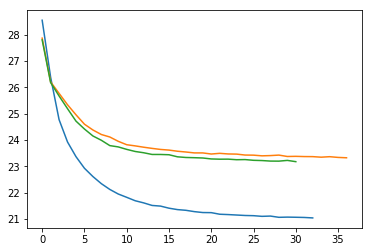

In [78]:
plt.plot(loss)
plt.plot(loss1)
plt.plot(loss2)

In [32]:
import csv
from scipy.stats import spearmanr

In [61]:
dir_ = "sgns/datasets/"
for filename in os.listdir(dir_):
    if filename[-3:] != "npz":
    
        print (f"Dataset:             {filename[:-4]}")

        data = []
        with open(dir_+filename) as csvfile:
            spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
            for row in spamreader:
                word1, word2, score = row[0].split(";")
                data.append((word1, word2, np.float(score)))

        true_scores = []
        my_scores = []

        for i, r in enumerate(data):
            word1, word2, score = r
            if word1 in word_model.vocab and word2 in word_model.vocab:
                true_scores.append(score)
                index1 = word_model.vocab[word1]
                index2 = word_model.vocab[word2]
                my_score = cosine_similarity(
                    word_model.W[:,index1][None,:], word_model.W[:,index2][None,:])[0,0]
                my_scores.append(my_score)

        print ("Correlation:        ", spearmanr(true_scores, my_scores)[0])
        print (f"Words in vocabulary: {len(my_scores)} out of {i}")
        print ("")

Dataset:             wordsim353
Correlation:         0.4302686779350769
Words in vocabulary: 319 out of 352

Dataset:             rw2034
Correlation:         0.41197484104153936
Words in vocabulary: 421 out of 2033

Dataset:             mturk771
Correlation:         0.38072332105847384
Words in vocabulary: 743 out of 770

Dataset:             simlex999
Correlation:         0.2727231304810342
Words in vocabulary: 940 out of 998

Dataset:             rg65
Correlation:         0.6967427156071124
Words in vocabulary: 54 out of 64

Dataset:             verb143
Correlation:         0.3233272525398496
Words in vocabulary: 144 out of 143

Dataset:             mturk287
Correlation:         0.23474996860731878
Words in vocabulary: 273 out of 286

Dataset:             wordsim_sim
Correlation:         0.5557166825741511
Words in vocabulary: 184 out of 202

Dataset:             wordsim_rel
Correlation:         0.23847321132457064
Words in vocabulary: 230 out of 251

Dataset:             men3000
Cor

In [104]:
dir_ = "sgns/datasets/"
for filename in os.listdir(dir_):
    if filename[-3:] != "npz":
    
        print (f"Dataset:             {filename[:-4]}")

        data = []
        with open(dir_+filename) as csvfile:
            spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
            for row in spamreader:
                word1, word2, score = row[0].split(";")
                data.append((word1, word2, np.float(score)))

        true_scores = []
        my_scores = []

        for i, r in enumerate(data):
            word1, word2, score = r
            if word1 in word_model.vocab and word2 in word_model.vocab:
                true_scores.append(score)
                index1 = word_model.vocab[word1]
                index2 = word_model.vocab[word2]
                my_score = cosine_similarity(
                    word_model.W[:,index1][None,:], word_model.W[:,index2][None,:])[0,0]
                my_scores.append(my_score)

        print ("Correlation:        ", spearmanr(true_scores, my_scores)[0])
        print (f"Words in vocabulary: {len(my_scores)} out of {i}")
        print ("")

Dataset:             wordsim353
Correlation:         0.42470523646717273
Words in vocabulary: 319 out of 352

Dataset:             rw2034
Correlation:         0.4073292597966276
Words in vocabulary: 421 out of 2033

Dataset:             mturk771
Correlation:         0.3652367572585445
Words in vocabulary: 743 out of 770

Dataset:             simlex999
Correlation:         0.2589006201762877
Words in vocabulary: 940 out of 998

Dataset:             rg65
Correlation:         0.6464253731953941
Words in vocabulary: 54 out of 64

Dataset:             verb143
Correlation:         0.29024278116714125
Words in vocabulary: 144 out of 143

Dataset:             mturk287
Correlation:         0.26446453108301604
Words in vocabulary: 273 out of 286

Dataset:             wordsim_sim
Correlation:         0.540837709669679
Words in vocabulary: 184 out of 202

Dataset:             wordsim_rel
Correlation:         0.233255068696923
Words in vocabulary: 230 out of 251

Dataset:             men3000
Correl

In [46]:
i

202

In [41]:
true_scores = []
my_scores = []

for r in data:
    word1, word2, score = r
    if word1 in word_model.vocab and word2 in word_model.vocab:
        true_scores.append(score)
        index1 = word_model.vocab[word1]
        index2 = word_model.vocab[word2]
        my_score = cosine_similarity(
            word_model.W[:,index1][None,:], word_model.W[:,index2][None,:])[0,0]
        my_scores.append(my_score)

In [42]:
spearmanr(true_scores, my_scores)

SpearmanrResult(correlation=0.5557166825741511, pvalue=2.6549636984624055e-16)

In [43]:
len(my_scores)

184